# Threshold-based QoE Model (TBQ)
This Jupyter notebook implements the TBQ model and in particular the transformation of the TBQ model to estimate the system PoW. The System PoW is the ratio of users in a system who rate the quality as poor or worse. It is the average of PoW values based on a QoS–PoW mapping function. The transformation, however, allows to use an QoS-MOS mapping function instead of the PoW mapping function, since literature often reports MOS mapping functions.

The TBQ Model is defined in the following article:

>"Industrial User Experience Index vs. Quality of Experience Models" by Tobias Hoßfeld, Anika Seufert, Frank Loh, Stefan Wunderer, John Davies, accepted for publication in IEEE Communications Magazine (2022)

## System QoE and System PoW
During operation of a real-world system, an operator is interested to quantify the *QoE* of the user *in that system*. Various QoE metrics may be of interest for the operator, like the *expected (i.e. average) QoE* of a user in the system or the *ratio of users in the system with poor or worse (PoW) quality*. To obtain the system QoE or system PoW, the users rate the service consumed under the varying QoS conditions. Then, the resulting QoE distribution of user ratings in the system is a random variable, denoted as $Q$. The expected QoE $E[Q]$ is referred to as expected system QoE, while the system PoW is the probability that the user rating is poor or worse $P(Q\leq 2)$. 
Note that the definition of system QoE and system PoW only consider the user ratings.

However, in such a real system, the operator cannot always ask the users to rate the service. To this end, we utilize the fundamental relationships for deriving QoE in systems by Hossfeld et al. (2020). Let us consider subjective user studies. Users are rating the QoE for a fixed QoS and system conditions $x$, e.g. an average video bitrate of $x=\SI{1}{Mbps}$. Then, the user ratings under condition $x$ are a conditional random variable $Q|x$.  The mean opinion score (MOS) is simply the average or expected QoE $E[Q|x]$ and we obtain a MOS mapping function $f(x)=E[Q|x]$. However, the QoS condition in the system are also a random variable $X$ with probability density function $h(x)$. Then, the fundamental relationship is obtained.

$$
E[Q]=\int_x E[Q|x] \cdot h(x) \; dx = \int_x f(x) \cdot h(x) \; dx = E[f(X)]
$$

**System QoE $E[Q]$** is the expected (i.e. average) QoE of a user in a considered system. It is the average $E[f(X)]$ of MOS values based on a QoS–MOS mapping function $f(X)$.

In a similar way, the fundamental relationship between the PoW ratio of users in the system and the QoS measurements is derived by using a PoW mapping function $g(x)$ instead of a MOS mapping function, which is also obtained by subjective user studies. 

$$
PoW[Q]=P(Q\leq 2)=E[g(X)] 
$$

A formal proof is provided by Hossfeld et al. (2020) for those fundamental relationships. In practice, the operator measures the QoS, applies the PoW mapping function to the QoS measurements, and computes the average to quantify the PoW ratio. 

> T. Hoßfeld, P. E. Heegaard, L. Skorin-Kapov, and M. Varela, “Deriving
QoE in Systems: from Fundamental Relationships to a QoE-based
Service-level Quality Index,” Quality and User Experience, vol. 5, no. 1,
pp. 1–17, 2020

## TBQ Model
So we have seen how to calculate the real system QoE and system PoW, but how does it work with the TBQ model? The TBQ model defines thresholds for the QoS parameters and then yields a discrete QoE score, for example, 1,2,3,4,5 for bad, poor, fair, good, excellent quality, respectively. The TBQ model and the thresholds are typically chosen to reflect *an average user*. Hence, we obtain a QoS-MOS mapping function $b(x)$ for QoS values $x$.

For deriving now the **system TBQ**, we are following the same procedure as for the system QoE. 
The TBQ model is applied to the collected QoS measurements $X$ and we obtain the random variable $B=b(X)$ indicating the QoE of the average user. 

$$B=b(X)$$

Then, the average $E[b(x)]$ of TBQ scores reflects the system TBQ.

$$E[B]=E[b(x)]$$

Note that the mapping function $b(x)$ is discrete, while typically QoS-MOS mapping functions $f(x)$ are continuous. 

The TBQ PoW is also defined on the basis of the TBQ scores. Hence, the TBQ model considers a system which only consists of *'average users'*. Then, the ratio of the average users obtaining a poor or worse quality yields the TBQ PoW. **TBQ PoW** is the proportion of average users in that system with poor or worse quality based on the defined thresholds of the TBQ model.

$$
PoW[B] = P(B\leq 2) = P(b(X)\leq 2)
$$

*Does the TBQ model result in the true system QoE? Does the TBQ model result in the system PoW? Can we transform the TBQ model results to obtain the system PoW?* This will be shown in the notebook.

## Example: MOS and PoW Functions
We consider the example of video streaming. The video bitrate $x$ is mapped to MOS and PoW values.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import beta
from scipy import interpolate

def powBetaDist(m,sosa=0.25,a=1,b=5):
    alpha = (1-sosa)*(m-1)/(sosa*(b-a))
    be = (1-sosa)*(b-m)/(sosa*(b-a))
    rv = beta(alpha,be, loc=a, scale=b-a)
    return rv.cdf(2.5)

def QoE_bitrate(b,Rmin=0.1):
    R = np.log(b/Rmin)
    return np.maximum(1,np.minimum(5,R))


a, b= 0.3, 15
xx = np.linspace(a,b,10000)
yy = np.array([powBetaDist(QoE_bitrate(x)) for x in xx])
i= ~np.isnan(yy)

pow_fun = interpolate.interp1d(xx[i], yy[i]) # This is our true PoW mapping function
mos_fun = QoE_bitrate # This is our true MOS mapping function

### Plotting the mapping functions
Now we plot the QoS-MOS mapping function $f(x)$ and define the TBQ model $b(x)$.

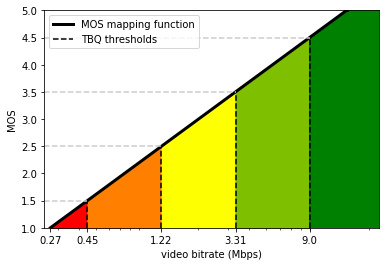

In [8]:
tbq_bitrates = np.exp([1,1.5,2.5,3.5,4.5]+np.log(0.1))
x = np.linspace(tbq_bitrates[0],b,200)
plt.plot(x,mos_fun(x), 'k-', linewidth=3, label='MOS mapping function')

cmap = LinearSegmentedColormap.from_list('name', ['red', 'yellow', 'green'])
colors = cmap(np.linspace(0, 1, 5))

for i in range(4):
    x = tbq_bitrates[i+1]
    plt.plot([x,x],[1,mos_fun(x)], 'k--')
    plt.plot([0.25,x],[mos_fun(x),mos_fun(x)], '--', color=[0.8]*3)
    myx = np.linspace(tbq_bitrates[i],tbq_bitrates[i+1],50)
    plt.fill_between(myx, mos_fun(myx), color=colors[i,:])

myx = np.linspace(tbq_bitrates[-1],23,50)    
plt.fill_between(myx, mos_fun(myx), color=colors[-1,:])
plt.xscale('log')
plt.ylim([1,5])
plt.xlim([0.25,myx[-1]])
plt.xlabel('video bitrate (Mbps)')
plt.ylabel('MOS')
plt.legend(['MOS mapping function', 'TBQ thresholds'],loc='best')
plt.xticks(ticks=tbq_bitrates, labels=np.round(tbq_bitrates,decimals=2));

### Definition of TBQ Model
We simply check the thresholds and assign the discrete QoE scores. For a given video bitrate `mbps`, the functions provide the TBQ score and the correspoinding TBQ PoW values.

In [5]:
bitrates = np.exp(np.arange(1,6)+np.log(0.1))
tbq_bitrates = np.exp([1,1.5,2.5,3.5,4.5]+np.log(0.1))


pow_bitrates  = np.exp([1,2,3,4,5]+np.log(0.1))
tbq_powvals = np.insert(np.insert(pow_fun(tbq_bitrates[1:]),0,1),5,0)


def TBQmodel(mbps):
    q = np.digitize(mbps, tbq_bitrates)
    return q

def TBQPowmodel(mbps):
    q = np.digitize(mbps, tbq_bitrates)
    return tbq_powvals[q]

### System QoS Conditions and True QoE Distribution
We consider varying system QoS conditions (random variable, r.v.) which lead to the corresponding QoE $Q$ (r.v.). Thus, we define `getRVForMeanAndStd` which returns the corresponding r.v. $Q$.

In [7]:
def getRVForMeanAndStd(mu=4.0, sigma=1.0, a=1, b=5):
    lam = (mu-a)*(b-mu)/sigma**2-1
    alpha = lam*(mu-a)/(b-a)
    be = lam*(b-mu)/(b-a)
    rv = beta(alpha,be, loc=a, scale=b-a)
    return rv

### Simulate True QoE Distributions
We consider now different QoE distributions with mean $\mu$ and standard deviation $\sigma$. Hence, $\mu$ is the true system QoE. Accordingly, we derive the TBQ scores.

In [13]:
import scipy.integrate as integrate
import warnings
warnings.filterwarnings("ignore")


mus = np.linspace(1,5,100)
sigmas = [0.1, 0.25, 0.5]
tbqs = np.zeros((len(mus),len(sigmas)))

for i,m in enumerate(mus):
    for j,s in enumerate(sigmas):
        rv = getRVForMeanAndStd(mu=m,sigma=s)
        tbqs[i,j] = integrate.quad(lambda x: np.round(x)*rv.pdf(x), 1, 5)[0]

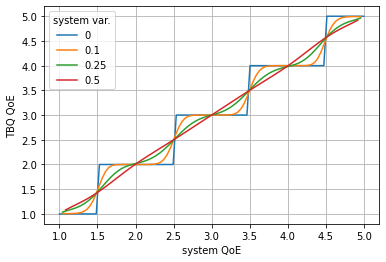

In [14]:
plt.plot(mus, np.round(mus), label='0')
for j,s in enumerate(sigmas):
    plt.plot(mus, tbqs[:,j], label=s)
plt.xlabel('system QoE')
plt.ylabel('TBQ QoE')
plt.legend(title='system var.')
plt.grid(which='major');

We observe that the TBQ QoE is close to the system QoE. This is expected, since the TBQ model considers an average user and the system QoE is the true expected (i.e. average) QoE of a user in the system. The discrepancy is only caused by the finite mapping to the QoE scores 1,2,3,4,5 by the TBQ model. If more classes are used, the error gets smaller. However, in practice, it is more difficult to find fine-granular thresholds.

### TBQ PoW vs. System PoW
Now, let's compare the TBQ PoW and the system PoW. There are strong differences!

In [21]:
mu = 2.0 # true average QoE
sigma = 1.0 # standard deviation of QoE

# check if parameter (mu, sigma) are possible with a Beta distribution
def checkBeta(mean,std, a, b, f=1):
    m = (mean-a)/(b-a)
    s = std/(b-a)
    return True if s**2<m*(1-m)*f else False

if not checkBeta(mu, sigma, a,b) or not checkBeta(mu, 2*sigma, a,b):
    raise Warning('wrong parameters')

    
    
X = getRVForMeanAndStd(mu=mu, sigma=sigma, a=a, b=b-0.2) # video bitrates 

qos = X.rvs(size=1000) # 1000 QoS measurements

system_qoe = mos_fun(qos).mean()
system_pow = pow_fun(qos).mean()

# optimal TBQ thresholds: rounding of MOS mapping function
tbq_scores = np.round(mos_fun(qos))
tbq_qoe = tbq_scores.mean()
tbq_pow = np.sum(tbq_scores<=2)/len(tbq_scores)

print(f'System QoE {system_qoe:g} vs. TBQ QoE {tbq_qoe:g}')
print(f'System PoW {system_pow:g} vs. TBQ PoW {tbq_pow:g}')


System QoE 2.85837 vs. TBQ QoE 2.868
System PoW 0.408428 vs. TBQ PoW 0.223


### Transformation
For a given MOS score, we are not able to derive the entire user rating distribution. However, we can assume a certain user rating diversity which is expressed in terms of the SOS parameter $a$. Then we can compute the entire distribution based on that assumption of $a$. Since $a$ is not known, we may simple assume a low user rating diversity $a_1=0.1$ and a high user rating diversity $a_2=0.25$, respectively. This will result into two corresponding PoW values $p_1(m,a_1)$ and $p_2(m,a_2)$. Then, we approximate the PoW mapping functions using the average of $p_1$ and $p_2$. 

Hence, we approximate the PoW mapping functions and then return the mean. This will give us a transformed TBQ PoW which is closer to the system PoW.

In [27]:
def transformTBQ_pow(tbq_scores):   
    
    def transformTBQ(m):    
        if m==5:
            return 0 
        elif m==1:
            return 1
        else:
            pows = np.zeros(2)
            for i,a in enumerate([0.1, 0.25]):        
                alpha = (1-a)*(m-1)/(4*a)
                be = (1-a)*(5-m)/(4*a)            
                pows[i] = (beta(alpha,be, loc=1, scale=4).cdf(2.5)) # THIS IS POW NOW        
        y=pows.mean()
        if np.isnan(y):
            return 0
        else:
            return y
        
    y = np.zeros(len(tbq_scores))
    for i,m in enumerate(tbq_scores):
        y[i] = transformTBQ(m)
        
    return y.mean()

print(f'System PoW {system_pow:g} vs. TBQ PoW {tbq_pow:g} vs. transformed TBQ PoW {transformTBQ_pow(tbq_scores):g} ')    

System PoW 0.408428 vs. TBQ PoW 0.223 vs. transformed TBQ PoW 0.373657 
